This first part is only needed as we have to mock FHI-aims here as we cannot run it directly in a jupyter notebook:

In [1]:
import warnings

from mock_aims import TEST_DIR, mock_aims

ref_paths = {
    "Relaxation calculation": "phonon-relax-si",
    "phonon static aims 1/1": "phonon-disp-si",
    "SCF Calculation": "phonon-energy-si",
    "phonon static aims anharmonicity quant. 1/1": "anharm-si-full",
}

# Phonon Workflow Tutorial with FHI-aims

This tutorial has been written based on the VASP version.

## Background
The Phonon workflow is based on the finite displacement approach as implemented in Phonopy.

If you want to read more about Phonopy, please read Togo’s paper: https://doi.org/10.7566/JPSJ.92.012001

## Let's run the workflow
Now, we load a structure and other important functions and classes for running the phonon workflow.

In [2]:
from jobflow import JobStore, run_locally
from maggma.stores import MemoryStore
from pymatgen.core import Structure, Lattice

from atomate2.aims.flows.phonons import PhononMaker

warnings.filterwarnings("ignore")

job_store = JobStore(MemoryStore(), additional_stores={"data": MemoryStore()})
si_structure = Structure.from_file(TEST_DIR / "structures" / "Si_diamond.cif")

Then one can use the `PhononMaker` to generate a `Flow`. For testing here, we are choosing a very small supercell length (`min_length`). Ideally, a larger cell should be chosen. For non-metallic systems with more than one element, one might need to add the non-analytical term correction considering very long-ranging forces by computing the `BORN` charges with the `born_maker`. Of course, the structure should also be relaxed in advance with the `bulk_relax_maker`. Please make sure this is done very accurately. For FHI-aims a `born_maker` still needs to be implemented.

In [3]:
phonon_maker = PhononMaker(
    min_length=3.0,
    generate_frequencies_eigenvectors_kwargs={"tstep": 100},
    create_thermal_displacements=True,
    store_force_constants=True,
    born_maker=None,
    use_symmetrized_structure="primitive",
)
flow = phonon_maker.make(si_structure)

The phonon run will first perform a bulk relaxation, then the displacements are generated and run.

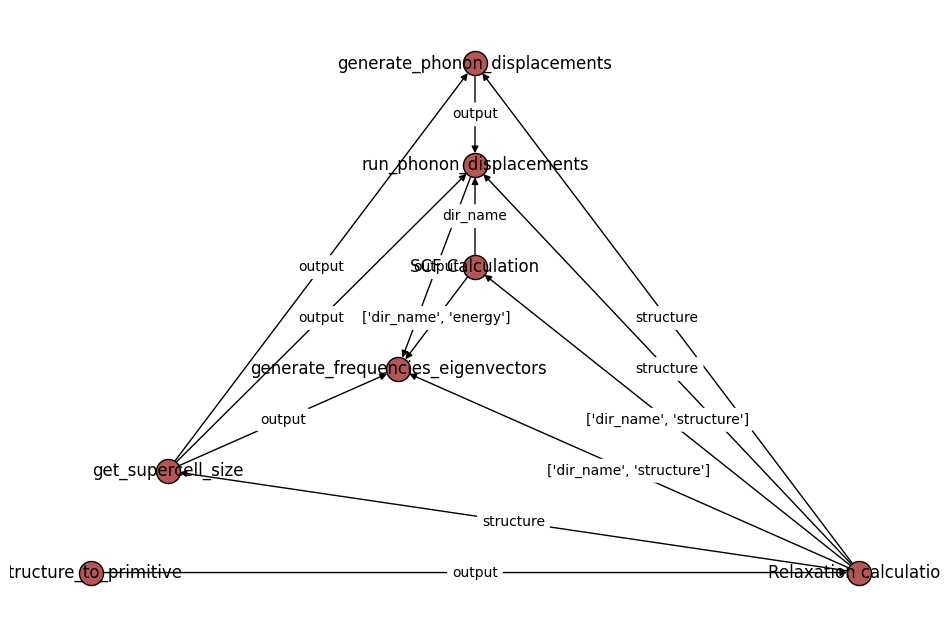

In [4]:
flow.draw_graph().show()

We now run the flow with  `run_locally`. We mock the run here. Normally, you would simply use `run_locally` without the `with mock_aims`

In [5]:
with mock_aims(ref_paths=ref_paths) as mf:
    run_locally(
        flow,
        create_folders=True,
        ensure_success=True,
        raise_immediately=True,
        store=job_store,
    )

2025-03-10 08:53:05,733 INFO Started executing jobs locally
2025-03-10 08:53:05,739 INFO Starting job - structure_to_primitive (1ec8b8da-e7e2-455a-b997-e7c2ddf7d124)
2025-03-10 08:53:05,761 INFO Finished job - structure_to_primitive (1ec8b8da-e7e2-455a-b997-e7c2ddf7d124)
2025-03-10 08:53:05,762 INFO Starting job - Relaxation calculation (d99fbdbe-273b-4acd-96ac-24396ab78598)



 {'xc': 'pbe', 'relativistic': 'atomic_zora scalar', 'relax_geometry': 'trm 1.000000e-03', 'relax_unit_cell': 'full', 'k_grid': [10, 10, 10], 'output': []} 






 /home/purcellt/git/FHIaims/species_defaults/defaults_2020/tight/ 



2025-03-10 08:53:05,813 INFO Finished job - Relaxation calculation (d99fbdbe-273b-4acd-96ac-24396ab78598)
2025-03-10 08:53:05,814 INFO Starting job - get_supercell_size (09dd6249-eaaf-44f6-82c4-6101c08341fa)
2025-03-10 08:53:05,821 INFO Finished job - get_supercell_size (09dd6249-eaaf-44f6-82c4-6101c08341fa)
2025-03-10 08:53:05,822 INFO Starting job - SCF Calculation (c3941fc0-976a-4

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


2025-03-10 08:53:13,060 INFO Finished job - generate_frequencies_eigenvectors (1b0f2cc0-99b6-40df-9c05-dee314c7a69f)
2025-03-10 08:53:13,061 INFO Finished executing jobs locally


In [6]:
from pymatgen.phonon.bandstructure import PhononBandStructureSymmLine
from pymatgen.phonon.dos import PhononDos
from pymatgen.phonon.plotter import PhononBSPlotter, PhononDosPlotter

job_store.connect()

result = job_store.query_one(
    {"name": "generate_frequencies_eigenvectors"},
    load=True,
    sort={"completed_at": -1},  # to get the latest computation
)

<Axes: xlabel='$\\mathrm{Wave\\ Vector}$', ylabel='$\\mathrm{Frequencies\\ (THz)}$'>

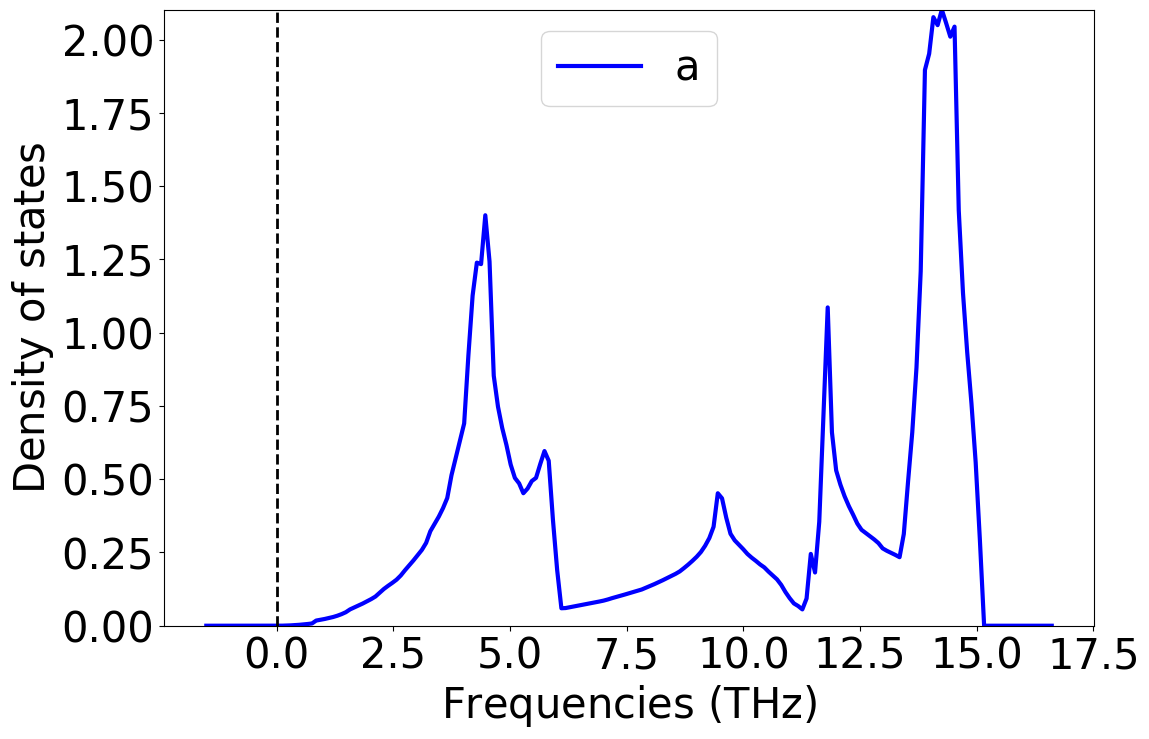

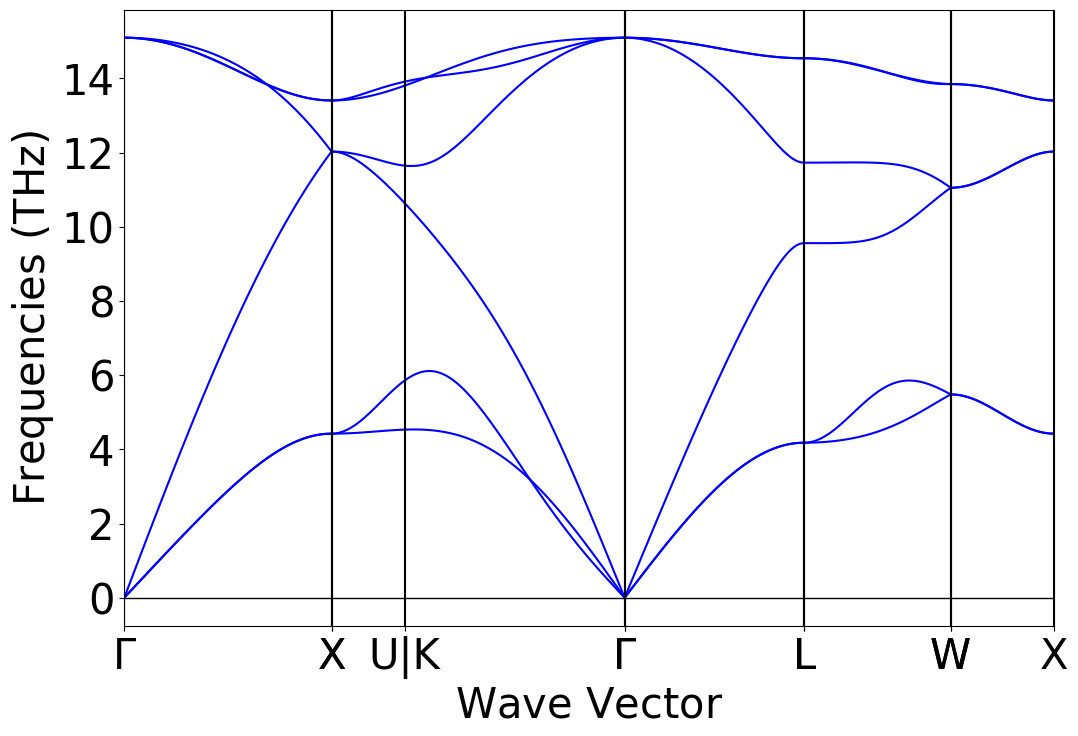

In [7]:
ph_bs = PhononBandStructureSymmLine.from_dict(
    result["output"]["phonon_bandstructure"]
)  # get pymatgen bandstructure object
ph_dos = PhononDos.from_dict(
    result["output"]["phonon_dos"]
)  # get pymatgen phonon dos object

# initialize dos plotter and visualize dos plot
dos_plot = PhononDosPlotter()
dos_plot.add_dos(label="a", dos=ph_dos)
dos_plot.get_plot()

# initialize Phonon bandstructure plotter and visualize band structure plot
bs_plot = PhononBSPlotter(bs=ph_bs)
bs_plot.get_plot()

One can run the same workflow with a forcefield or VASP as well.

## Anharmonicity Quantification

Now that we have a phonon calculation completed, we can quantify the anharmonicty ($\sigma^A$) using the method first proposed in this paper: Phys. Rev. Materials 4, 083809 DOI: https://doi.org/10.1103/PhysRevMaterials.4.083809

In [8]:
from atomate2.aims.flows.anharmonicity import AnharmonicityMaker
from atomate2.common.schemas.phonons import PhononBSDOSDoc
import numpy as np

anharm_quant_maker = AnharmonicityMaker(phonon_maker=phonon_maker)
phonon_doc = PhononBSDOSDoc(**result["output"])

anharm_flow = anharm_quant_maker.make_from_phonon_doc(
    phonon_doc=phonon_doc,
    one_shot_approx=False,
    seed=1234,
)

In [9]:
with mock_aims(ref_paths=ref_paths) as mf:
    run_locally(
        anharm_flow,
        create_folders=True,
        ensure_success=True,
        raise_immediately=True,
        store=job_store,
    )

2025-03-10 08:53:13,436 INFO Started executing jobs locally
2025-03-10 08:53:13,441 INFO Starting job - get_phonon_supercell (259c23c1-2f7c-498d-b5a0-5a841b7fbe69)
2025-03-10 08:53:13,469 INFO Finished job - get_phonon_supercell (259c23c1-2f7c-498d-b5a0-5a841b7fbe69)
2025-03-10 08:53:13,470 INFO Starting job - displace_structure (ec457c94-faa5-45b9-80ef-839b63cd807e)
2025-03-10 08:53:13,475 INFO Finished job - displace_structure (ec457c94-faa5-45b9-80ef-839b63cd807e)
2025-03-10 08:53:13,475 INFO Starting job - run_displacements (ba62cbd3-841b-4730-9067-4cc2e793cd8b)
2025-03-10 08:53:13,479 INFO Finished job - run_displacements (ba62cbd3-841b-4730-9067-4cc2e793cd8b)
2025-03-10 08:53:13,481 INFO Starting job - phonon static aims anharmonicity quant. 1/1 (223f001b-0250-4896-8c47-2500600acbbc)



 {'xc': 'pbe', 'relativistic': 'atomic_zora scalar', 'compute_forces': True, 'k_grid': [6, 6, 6], 'output': []} 






 /home/purcellt/git/FHIaims/species_defaults/defaults_2020/tight/ 



2025-03

In [10]:
result_anharm = job_store.query_one(
    {"name": "get_sigmas"},
    load=True,
    sort={"completed_at": -1},  # to get the latest computation
)
print(f"Estimated anharmonicity: {result_anharm['output']['full']}")

Estimated anharmonicity: 0.14426400177241192


We can also use the oneshot method to approximate $\sigma^A$

In [11]:
anharm_os_flow = anharm_quant_maker.make_from_phonon_doc(
    phonon_doc=phonon_doc,
    one_shot_approx=True,
    seed=1234,
)

In [12]:
run_locally(
    anharm_os_flow,
    create_folders=True,
    ensure_success=True,
    raise_immediately=True,
    store=job_store,
)

2025-03-10 08:53:39,909 INFO Started executing jobs locally
2025-03-10 08:53:39,924 INFO Starting job - get_phonon_supercell (bf5a7591-3c8f-4557-83e3-370bb89234de)
2025-03-10 08:53:40,021 INFO Finished job - get_phonon_supercell (bf5a7591-3c8f-4557-83e3-370bb89234de)
2025-03-10 08:53:40,025 INFO Starting job - displace_structure (ce524f6d-e34a-4bf3-838f-dbe6ca8b9947)
2025-03-10 08:53:40,050 INFO Finished job - displace_structure (ce524f6d-e34a-4bf3-838f-dbe6ca8b9947)
2025-03-10 08:53:40,052 INFO Starting job - run_displacements (c72a39d7-29d3-425e-9ecf-eee188fa88cf)
2025-03-10 08:53:40,068 INFO Finished job - run_displacements (c72a39d7-29d3-425e-9ecf-eee188fa88cf)
2025-03-10 08:53:40,075 INFO Starting job - phonon static aims anharmonicity quant. 1/1 (de7e22de-2e9d-4ab1-9831-3fc9bb29c3f3)



 {'xc': 'pbe', 'relativistic': 'atomic_zora scalar', 'compute_forces': True, 'k_grid': [6, 6, 6], 'output': []} 






 /home/purcellt/git/FHIaims/species_defaults/defaults_2020/tight/ 



2025-03

{'bf5a7591-3c8f-4557-83e3-370bb89234de': {1: Response(output=Structure Summary
  Lattice
      abc : 5.472842510000051 5.472843850000016 5.472843850000015
   angles : 89.99999685926807 90.00000146567628 90.00000146567628
   volume : 163.9226872572833
        A : 5.4728425099999995 -5.299999998875649e-07 -5.299999997100167e-07
        B : 3.8999999985023237e-07 5.47284385 1.499999997100167e-07
        C : 3.8999999985023237e-07 1.4999999953246856e-07 5.472843849999999
      pbc : True True True
  PeriodicSite: Si (5.473, -5.2e-07, -5.2e-07) [1.0, 1.827e-09, 1.827e-09]
  PeriodicSite: Si (5.473, 2.736, 2.736) [1.0, 0.5, 0.5]
  PeriodicSite: Si (2.736, -1.8e-07, 2.736) [0.5, 1.827e-09, 0.5]
  PeriodicSite: Si (2.736, 2.736, -1.8e-07) [0.5, 0.5, 1.827e-09]
  PeriodicSite: Si (1.368, 1.368, 1.368) [0.25, 0.25, 0.25]
  PeriodicSite: Si (1.368, 4.105, 4.105) [0.25, 0.75, 0.75]
  PeriodicSite: Si (4.105, 1.368, 4.105) [0.75, 0.25, 0.75]
  PeriodicSite: Si (4.105, 4.105, 1.368) [0.75, 0.75, 0.2

In [14]:
result_anharm = job_store.query_one(
    {"name": "get_sigmas"},
    load=True,
    sort={"completed_at": -1},  # to get the latest computation
)
print(f"Estimated anharmonicity: {result_anharm['output']['one-shot']}")

{'one-shot': 0.12017874244160545}
Estimated anharmonicity: 0.12017874244160545
